**GOAL**:
- get relative positions of each of the hooves
- For Zeni algorithm

In [1]:
import numpy as np
import pandas as pd
# import deeplabcut
# import torch
from pathlib import Path

In [2]:
h5_file = 'processed_vids/deer2_superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_.h5'
pose_data = pd.read_hdf(h5_file)

pose_data = pose_data.sort_index(axis=1)

In [3]:
pose_data

scorer      superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_  \
individuals                                                     animal0   
bodyparts                                                     back_base   
coords                                                       likelihood   
0                                                     0.014207            
1                                                     0.022539            
2                                                     0.025167            
3                                                     0.047044            
4                                                     0.013458            
..                                                         ...            
610                                                   0.384946            
611                                                   0.410142            
612                                                   0.384520            
613                                                   0.437993            
614                                                   0.367385            

scorer                                                                  \
individuals                                                              
bodyparts                             back_end                           
coords                x           y likelihood           x           y   
0            367.023438  176.054688   0.763108  239.976562  219.304688   
1            388.898438  169.429688   0.732230  244.195312  216.679688   
2            386.906250  207.835938   0.711897  242.031250  215.429688   
3            307.382812  213.585938   0.706119  243.554688  206.867188   
4            388.484375  218.023438   0.251928  247.171875  203.210938   
..                  ...         ...        ...         ...         ...   
610          355.570312  260.429688   0.822463  216.242188  275.492188   
611          345.687500  270.976562   0.857489  213.937500  278.695312   
612          346.523438  275.718750   0.873518  205.335938  287.531250   
613          340.960938  284.835938   0.832556  204.273438  296.226562   
614          335.656250  289.835938   0.856896  194.593750  301.226562   

scorer                                                            ...  \
individuals                                                       ...   
bodyparts   back_left_knee                         back_left_paw  ...   
coords          likelihood           x           y    likelihood  ...   
0                 0.460591  239.976562  294.992188      0.484380  ...   
1                 0.700803  247.148438  287.554688      0.541245  ...   
2                 0.694743  249.656250  279.976562      0.611155  ...   
3                 0.660738  246.914062  274.054688      0.396257  ...   
4                 0.436350  258.328125  273.570312      0.381618  ...   
..                     ...         ...         ...           ...  ...   
610               0.960003  231.304688  362.101562      0.891875  ...   
611               0.855104  229.437500  367.460938      0.845014  ...   
612               0.903228  224.945312  378.093750      0.871995  ...   
613               0.881311  219.460938  383.554688      0.864184  ...   
614               0.902020  209.843750  388.554688      0.875545  ...   

scorer                                                                  \
individuals                                                              
bodyparts      tail_end throat_base                         throat_end   
coords                y  likelihood           x           y likelihood   
0            238.226562    0.024649  350.804688  211.195312   0.033894   
1            228.492188    0.063446  388.898438  166.476562   0.052405   
2            219.226562    0.102740  394.531250  177.460938   0.051024   
3            220.304688    0.069175  384.648438  190.070312   0.041592   
4            210.617188    0.073937  258.328125  321.710938   0.017864   
.

In [4]:
bodyparts = pose_data.columns.get_level_values('bodyparts').unique()
print("Body parts:", bodyparts)

Body parts: Index(['back_base', 'back_end', 'back_left_knee', 'back_left_paw',
       'back_left_thai', 'back_middle', 'back_right_knee', 'back_right_paw',
       'back_right_thai', 'belly_bottom', 'body_middle_left',
       'body_middle_right', 'front_left_knee', 'front_left_paw',
       'front_left_thai', 'front_right_knee', 'front_right_paw',
       'front_right_thai', 'left_antler_base', 'left_antler_end',
       'left_earbase', 'left_earend', 'left_eye', 'lower_jaw',
       'mouth_end_left', 'mouth_end_right', 'neck_base', 'neck_end', 'nose',
       'right_antler_base', 'right_antler_end', 'right_earbase',
       'right_earend', 'right_eye', 'tail_base', 'tail_end', 'throat_base',
       'throat_end', 'upper_jaw'],
      dtype='object', name='bodyparts')


In [5]:
# Define paws and their reference points
front_paws = ['front_left_paw', 'front_right_paw']
back_paws = ['back_left_paw', 'back_right_paw']
front_ref = 'back_base'
back_ref = 'tail_base'

# Get coordinate levels (typically 'x', 'y', 'likelihood')
coords = pose_data.columns.get_level_values('coords').unique()
print("Coordinate columns:", coords)

Coordinate columns: Index(['likelihood', 'x', 'y'], dtype='object', name='coords')


In [6]:
# Function to extract coordinates for a body part
def get_coords(df, bodypart, coord='x'):
    """Extract coordinates for a specific body part."""
    scorer = df.columns.get_level_values(0).unique()[0]
    individual = df.columns.get_level_values(1).unique()[0]

    coords = df[(scorer, individual, bodypart)][[coord]]

    return coords


# Extract reference point coordinates
back_base_x = get_coords(pose_data, front_ref, 'x')
back_base_y = get_coords(pose_data, front_ref, 'y')
tail_base_x = get_coords(pose_data, back_ref, 'x')
tail_base_y = get_coords(pose_data, back_ref, 'y')

print(f"Reference points extracted:")
print(f"  {front_ref}: {len(back_base_x)} frames")
print(f"  {back_ref}: {len(tail_base_x)} frames")

Reference points extracted:
  back_base: 615 frames
  tail_base: 615 frames


In [7]:
# Create new dataframe with same structure as original, including relative positions as new bodyparts
# Start with a copy of the original data
pose_data_with_rel = pose_data.copy()

scorer = pose_data.columns.get_level_values(0).unique()[0]
individual = pose_data.columns.get_level_values(1).unique()[0]

# Calculate relative positions for front paws (relative to back_base)
for paw in front_paws:
    paw_x = get_coords(pose_data, paw, 'x')
    paw_y = get_coords(pose_data, paw, 'y')
    
    # Create new bodypart name for relative position
    rel_bodypart = f'{paw}_rel'
    
    # Add relative x and y coordinates with same MultiIndex structure
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'x')] = paw_x - back_base_x
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'y')] = paw_y - back_base_y
    # Set likelihood to same as original paw
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'likelihood')] = pose_data_with_rel[(scorer, individual, paw, 'likelihood')]

# Calculate relative positions for back paws (relative to tail_base)
for paw in back_paws:
    paw_x = get_coords(pose_data, paw, 'x')
    paw_y = get_coords(pose_data, paw, 'y')
    
    # Create new bodypart name for relative position
    rel_bodypart = f'{paw}_rel'
    
    # Add relative x and y coordinates with same MultiIndex structure
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'x')] = paw_x - tail_base_x
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'y')] = paw_y - tail_base_y
    # Set likelihood to same as original paw
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'likelihood')] = pose_data_with_rel[(scorer, individual, paw, 'likelihood')]

# Sort columns lexicographically to maintain proper MultiIndex order
pose_data_with_rel = pose_data_with_rel.sort_index(axis=1)

print("Dataframe with relative positions created:")
print(f"Original shape: {pose_data.shape}")
print(f"New shape: {pose_data_with_rel.shape}")
print(f"\nNew bodyparts added:")
new_bodyparts = [bp for bp in pose_data_with_rel.columns.get_level_values('bodyparts').unique() 
                 if bp not in pose_data.columns.get_level_values('bodyparts').unique()]
print(new_bodyparts)
print(f"\nFirst few columns with new bodyparts:")
print(pose_data_with_rel.columns[pose_data_with_rel.columns.get_level_values('bodyparts').isin(new_bodyparts)][:6].tolist())

Dataframe with relative positions created:
Original shape: (615, 117)
New shape: (615, 129)

New bodyparts added:
['back_left_paw_rel', 'back_right_paw_rel', 'front_left_paw_rel', 'front_right_paw_rel']

First few columns with new bodyparts:
[('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_left_paw_rel', 'likelihood'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_left_paw_rel', 'x'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_left_paw_rel', 'y'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_right_paw_rel', 'likelihood'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_right_paw_rel', 'x'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_right_paw_rel', 'y')]


In [8]:
bodypart_level = pose_data_with_rel.columns.names.index('bodyparts')
rel_data = pose_data_with_rel[[col for col in pose_data_with_rel.columns if 'rel' in col[bodypart_level]]]
rel_data

scorer      superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_  \
individuals                                                     animal0   
bodyparts                                             back_left_paw_rel   
coords                                                       likelihood   
0                                                     0.484380            
1                                                     0.541245            
2                                                     0.611155            
3                                                     0.396257            
4                                                     0.381618            
..                                                         ...            
610                                                   0.891875            
611                                                   0.845014            
612                                                   0.871995            
613                                                   0.864184            
614                                                   0.875545            

scorer                                                                        \
individuals                                                                    
bodyparts                          back_right_paw_rel                          
coords               x           y         likelihood          x           y   
0            -5.406250  102.718750           0.611469  18.921875  113.531250   
1             2.953125  100.406250           0.642166   8.859375  112.218750   
2             7.625000  102.515625           0.665887  11.437500  110.109375   
3             3.359375  104.140625           0.761329  10.078125  117.578125   
4             7.437500  103.687500           0.611201   3.718750  111.093750   
..                 ...         ...                ...        ...         ...   
610          30.125000  143.093750           0.855225   0.000000  139.328125   
611          31.000000  146.656250           0.869773  -3.875000  142.796875   
612          31.375000  141.750000           0.867349   0.000000  141.750000   
613          30.375000  140.484375           0.888363  -3.796875  136.687500   
614          30.500000  144.281250           0.874623   0.000000  140.484375   

scorer                                                                      \
individuals                                                                  
bodyparts   front_left_paw_rel                         front_right_paw_rel   
coords              likelihood           x           y          likelihood   
0                     0.077460   10.812500   62.171875            0.114658   
1                     0.123414  -88.593750  183.093750            0.211289   
2                     0.041697  -64.812500  106.312500            0.098614   
3                     0.080875   13.437500  124.296875            0.178447   
4                     0.121745 -137.593750   88.875000            0.056742   
..                         ...         ...         ...                 ...   
610                   0.786931  -18.828125  158.156250            0.849263   
611                   0.792274  -11.625000  154.375000            0.816175   
612                   0.818290  -19.609375  157.500000            0.865720   
613                   0.744801  -18.984375  155.671875            0.840287   
614                   0.790999  -19.062500  159.468750            0.807327   

scorer                               
individuals                          
bodyparts                            
coords                x           y  
0            -72.984375  167.593750  
1            -88.593750  183.093750  
2           -122.000000  102.515625  
3            -13.437500  137.734375  
4           -137.593750   74.062500  
..                  ...         ...  
610          -15.062500  161.921875  
611           -7.750000  158.234375  
612          -15.687500  161.437500  
613     

In [9]:
# Optional: Save the dataframe with relative positions
# Uncomment the line below to save to HDF5
# pose_data_with_rel.to_hdf('processed_vids/pose_data_with_relative_positions.h5', key='pose_data', mode='w')

# Or save to CSV (note: CSV doesn't preserve MultiIndex structure well)
# pose_data_with_rel.to_csv('processed_vids/pose_data_with_relative_positions.csv', index=True)


In [10]:
from utils.vis import *
import importlib
import utils.vis

# After making changes to utils/vis.py, reload it:
importlib.reload(utils.vis)

<module 'utils.vis' from 'c:\\Users\\jexia\\OneDrive\\Documents\\projects\\datafawn\\utils\\vis.py'>

In [11]:
def compare_abs_and_rel(df, paw, min_likelihood=0.25):
    fig = plot_bodypart_movement(df, paw, individual='animal0', min_likelihood=min_likelihood)
    plt.show()

    fig = plot_bodypart_movement(df, paw+"_rel", individual='animal0', min_likelihood=min_likelihood)
    plt.show()

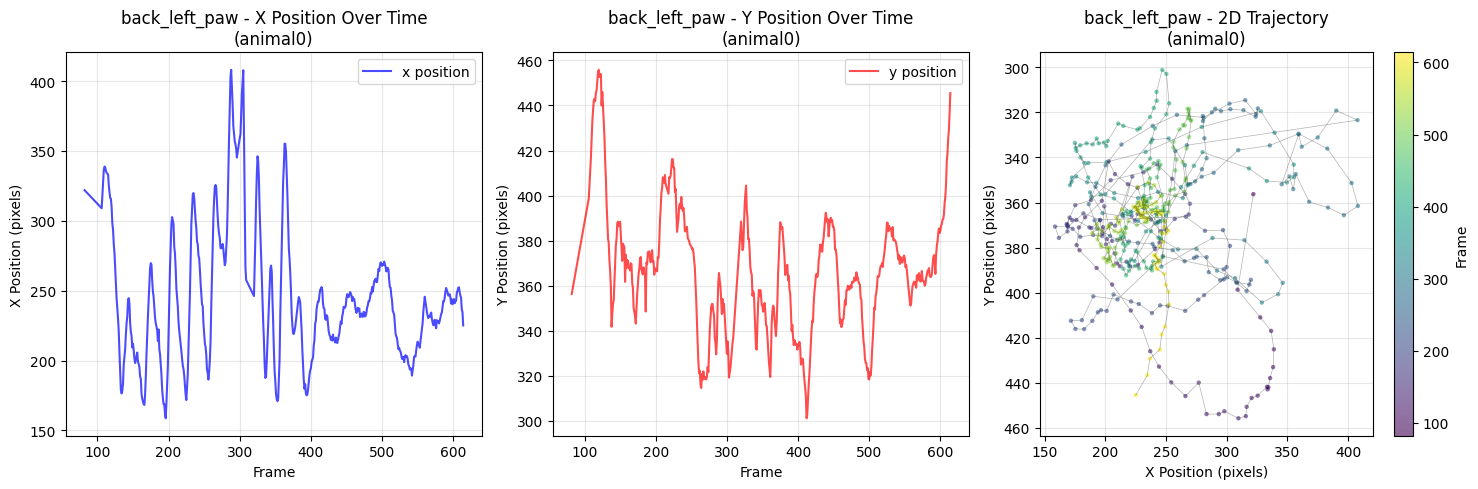

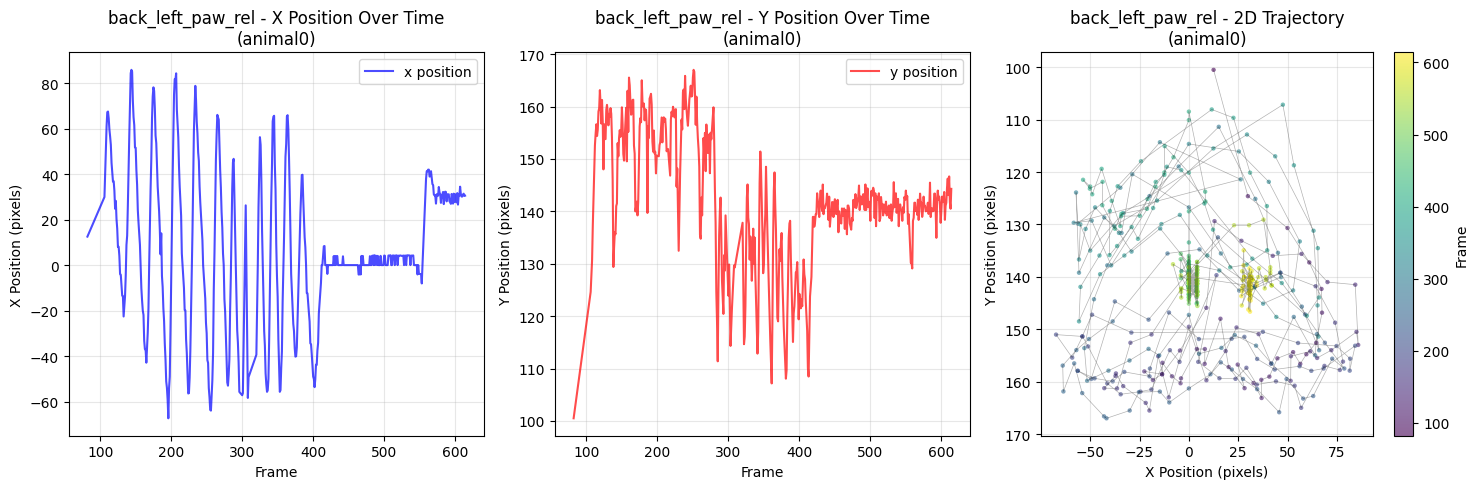

In [12]:
compare_abs_and_rel(pose_data_with_rel, 'back_left_paw', min_likelihood=0.75)
# compare_abs_and_rel(pose_data_with_rel, 'back_right_paw', min_likelihood=0.75)
# compare_abs_and_rel(pose_data_with_rel, 'front_left_paw', min_likelihood=0.75)
# compare_abs_and_rel(pose_data_with_rel, 'front_right_paw', min_likelihood=0.75)

In [31]:
def zeni_algorithm(pose_data_with_rel, 
                   min_likelihood=0.5,
                   window_size=5,
                   min_contact_duration=3,
                   velocity_threshold=10):
    """
    Zeni algorithm for detecting foot strikes (paw-ground contacts).
    
    The algorithm detects foot strikes by finding:
    1. Local maxima in vertical position (y-coordinate) - paw at lowest point
    2. Low velocity at contact point
    3. Minimum contact duration to filter noise
    
    Parameters:
    -----------
    pose_data_with_rel : pd.DataFrame
        DataFrame with relative positions (from pose_data_with_rel)
    min_likelihood : float, default=0.5
        Minimum likelihood threshold for valid detections
    window_size : int, default=5
        Window size for finding local maxima (should be odd)
    min_contact_duration : int, default=3
        Minimum number of consecutive frames for a valid contact
    velocity_threshold : float, default=10
        Maximum velocity (pixels/frame) at contact point
    
    Returns:
    --------
    strikes : dict
        Dictionary with paw names as keys and lists of frame indices as values
        where foot strikes occur
    """
    from scipy.signal import find_peaks
    from scipy.ndimage import uniform_filter1d
    
    scorer = pose_data_with_rel.columns.get_level_values(0).unique()[0]
    individual = pose_data_with_rel.columns.get_level_values(1).unique()[0]
    
    # Define paws and their relative bodypart names
    paws = {
        'front_left_paw': 'front_left_paw_rel',
        'front_right_paw': 'front_right_paw_rel',
        'back_left_paw': 'back_left_paw_rel',
        'back_right_paw': 'back_right_paw_rel'
    }
    
    strikes = {}
    
    for paw_name, rel_bodypart in paws.items():
        # Extract relative y-coordinate (vertical position)
        y_rel = pose_data_with_rel[(scorer, individual, rel_bodypart, 'y')]
        likelihood = pose_data_with_rel[(scorer, individual, rel_bodypart, 'likelihood')]
        
        # Filter by likelihood
        valid_mask = likelihood >= min_likelihood
        y_valid = y_rel.copy()
        y_valid[~valid_mask] = np.nan  # Mark invalid points
        
        # Smooth the signal to reduce noise
        y_smooth = pd.Series(
            uniform_filter1d(y_valid.fillna(method='ffill').fillna(method='bfill'), 
                            size=window_size),
            index=y_valid.index
        )
        
        # Calculate velocity (change in y per frame)
        velocity = np.abs(y_smooth.diff())
        
        # Find local maxima in y (lowest vertical position = foot strike)
        # Use prominence to avoid detecting small fluctuations
        # Prominence = minimum height difference from surrounding peaks
        y_array = y_smooth.values
        valid_indices = ~np.isnan(y_array)
        
        if np.sum(valid_indices) < window_size:
            # Not enough valid data
            strikes[paw_name] = []
            continue
        
        # Calculate prominence threshold (e.g., 5% of signal range)
        y_range = np.nanmax(y_array) - np.nanmin(y_array)
        prominence = max(y_range * 0.05, 5)  # At least 5 pixels or 5% of range
        
        # Find peaks (local maxima)
        peaks, properties = find_peaks(
            y_array,
            prominence=prominence,
            distance=window_size  # Minimum distance between peaks
        )
        
        # Filter peaks by velocity and likelihood
        valid_strikes = []
        for peak_idx in peaks:
            frame_idx = y_smooth.index[peak_idx]
            
            # Check velocity at contact point (should be low)
            if peak_idx < len(velocity):
                vel_at_contact = velocity.iloc[peak_idx]
                if vel_at_contact > velocity_threshold:
                    continue  # Too much movement, not a stable contact
            
            # Check likelihood
            if likelihood.iloc[peak_idx] < min_likelihood:
                continue
            
            # Check if this is part of a contact duration
            # Look for consecutive frames around the peak with similar y values
            contact_window = window_size
            start_idx = max(0, peak_idx - contact_window // 2)
            end_idx = min(len(y_smooth), peak_idx + contact_window // 2 + 1)
            
            window_y = y_smooth.iloc[start_idx:end_idx]
            window_likelihood = likelihood.iloc[start_idx:end_idx]
            
            # Count valid frames in window
            valid_in_window = np.sum(
                (window_likelihood >= min_likelihood) & 
                (~np.isnan(window_y))
            )
            
            if valid_in_window >= min_contact_duration:
                valid_strikes.append(int(frame_idx))
        
        strikes[paw_name] = sorted(valid_strikes)
    
    return strikes

In [32]:
strikes = zeni_algorithm(
    pose_data_with_rel,
    min_likelihood=0.5,
    window_size=5,
    min_contact_duration=3,
    velocity_threshold=10
)

C:\Users\jexia\AppData\Local\Temp\ipykernel_4052\3899512320.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uniform_filter1d(y_valid.fillna(method='ffill').fillna(method='bfill'),
C:\Users\jexia\AppData\Local\Temp\ipykernel_4052\3899512320.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uniform_filter1d(y_valid.fillna(method='ffill').fillna(method='bfill'),
C:\Users\jexia\AppData\Local\Temp\ipykernel_4052\3899512320.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uniform_filter1d(y_valid.fillna(method='ffill').fillna(method='bfill'),
C:\Users\jexia\AppData\Local\Temp\ipykernel_4052\3899512320.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or

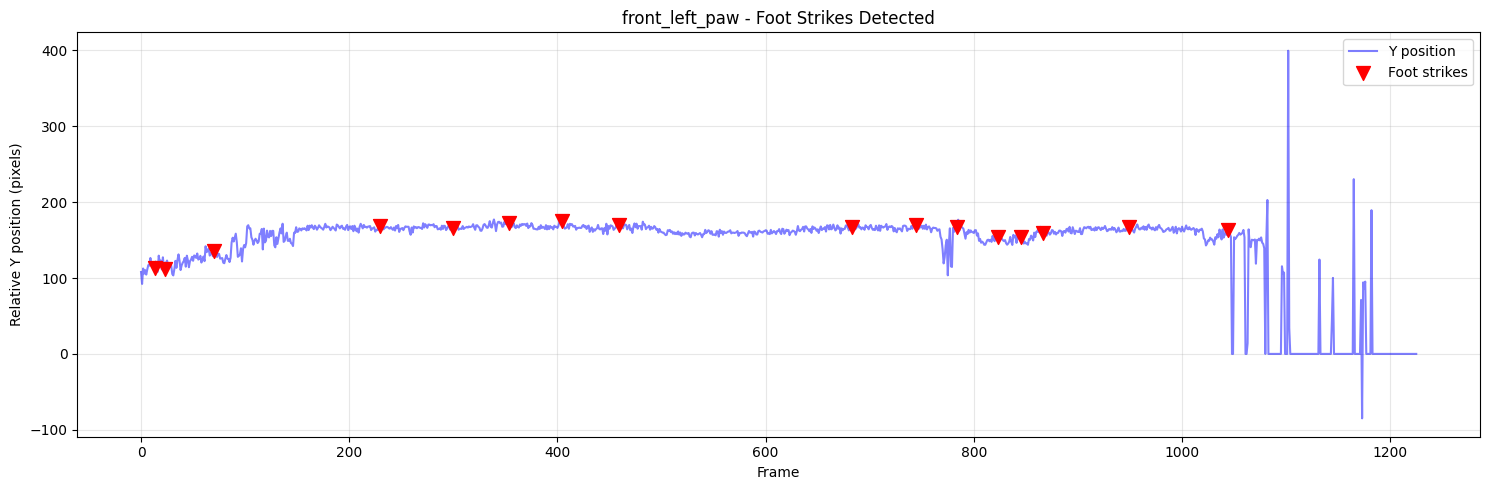

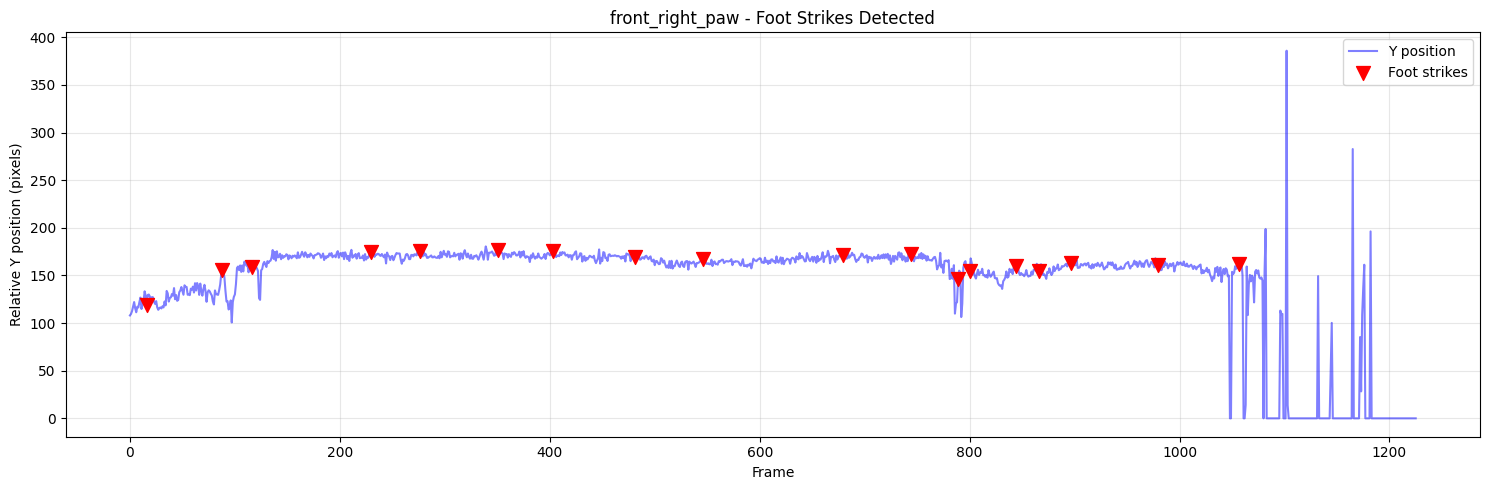

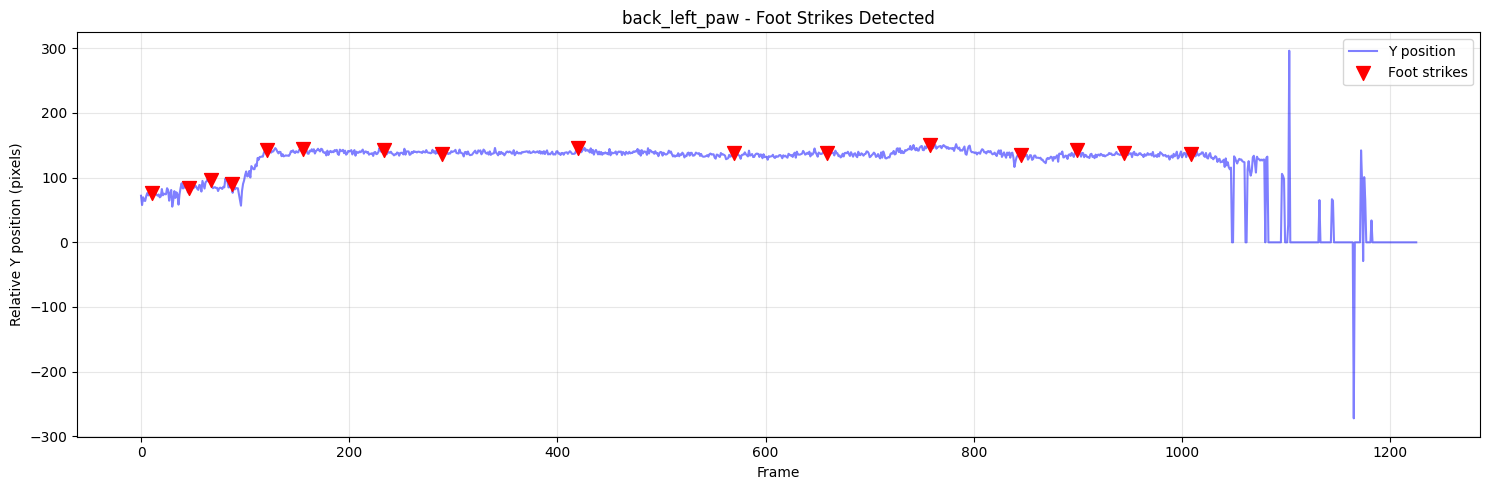

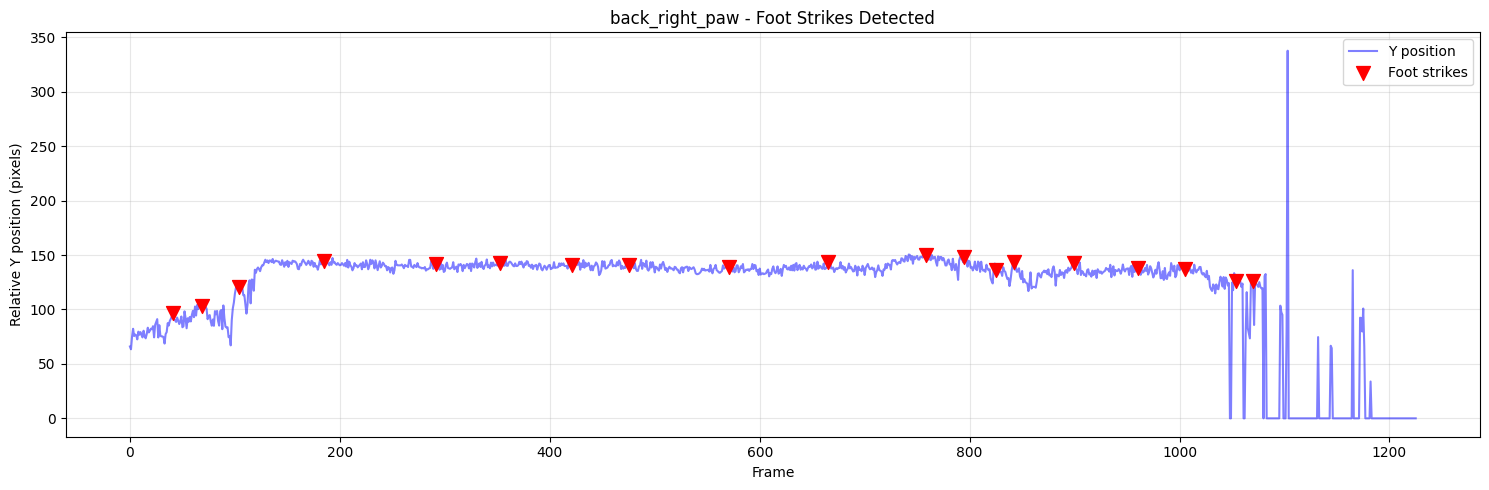

In [38]:
def plot_strikes(pose_data_with_rel, strikes, paw_name):
    """Plot paw movement with detected strikes marked."""
    import matplotlib.pyplot as plt
    
    scorer = pose_data_with_rel.columns.get_level_values(0).unique()[0]
    individual = pose_data_with_rel.columns.get_level_values(1).unique()[0]
    rel_bodypart = f'{paw_name}_rel'
    
    y_rel = pose_data_with_rel[(scorer, individual, rel_bodypart, 'y')]
    likelihood = pose_data_with_rel[(scorer, individual, rel_bodypart, 'likelihood')]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot y position
    ax.plot(y_rel.index, y_rel.values, 'b-', alpha=0.5, label='Y position')
    
    # Mark strikes
    strike_frames = strikes[paw_name]
    if len(strike_frames) > 0:
        strike_y = y_rel.loc[strike_frames]
        ax.scatter(strike_frames, strike_y.values, color='red', s=100, 
                  marker='v', label='Foot strikes', zorder=5)
    
    ax.set_xlabel('Frame')
    ax.set_ylabel('Relative Y position (pixels)')
    ax.set_title(f'{paw_name} - Foot Strikes Detected')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot results for each paw
for paw in ['front_left_paw', 'front_right_paw', 'back_left_paw', 'back_right_paw']:
    plot_strikes(pose_data_with_rel, strikes, paw)